<a href="https://colab.research.google.com/github/sudeep-009/Retail-Sales-Prediction/blob/dev/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rossmann_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/Rossmann Stores Data.csv')

In [ ]:
store_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/store.csv')


###Lets merged the two DataFrames

###Data Inspection

In [ ]:
merged_df = pd.merge(left=rossmann_df,right=store_df,how='left',on='Store')

In [ ]:
print('Number of columns present in the merged dataset is {}'.format(merged_df.shape[0]))
print('Number of columns present in the merged dataset is {}'.format(merged_df.shape[1]))

Number of columns present in the merged dataset is 1017209
Number of columns present in the merged dataset is 18


In [ ]:
print('Number of duplicate items present in the merged dataset is {}'.format(len(rossmann_df[rossmann_df.duplicated()])))

Number of duplicate items present in the merged dataset is 0


In [ ]:
pd.concat([merged_df.head(),merged_df.tail()])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
merged_df.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1017209,1017209,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01,NaN,NaN,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01,NaN,NaN,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,NaN
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,NaN
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00,NaN,NaN,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,NaN


###Exploratory Data Analysis

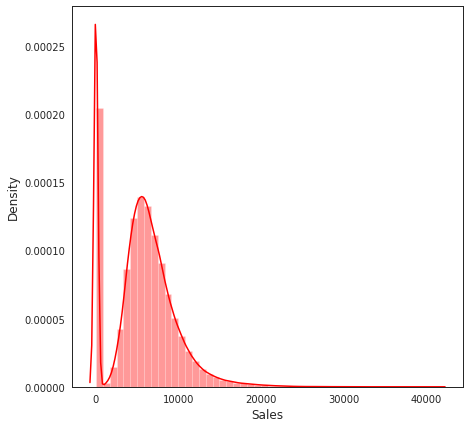

In [ ]:
# Dependent variable 'Price'
plt.figure(figsize=(7,7))
sns.distplot(merged_df['Sales'],color="r")

####High frequency corresponding to zero sales figure is because there are large number of observation where the Store is close due to State holiday or weekends. So we will remove all the observations where the sales is zero because of holiday.

**Finding**

There is no duplicated observation present in Rossmann dataset.

In [ ]:
rossmann_df.shape

(1017209, 9)

In [ ]:
pd.concat([rossmann_df.head(),rossmann_df.tail()])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
rossmann_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


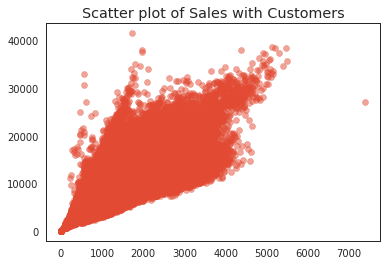

In [ ]:
plt.scatter(rossmann_df['Customers'], rossmann_df['Sales'], alpha=0.5)
plt.title('Scatter plot of Sales with Customers')
plt.show()

In [ ]:
store_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/store.csv')


In [ ]:
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
rossmann_df['DayOfWeek'].unique()
a = pd.to_datetime(rossmann_df['Date'])
pd.DatetimeIndex(a).dayofweek


Int64Index([4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='Date', length=1017209)

In [ ]:
rossmann_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [ ]:
rossmann_df['SchoolHoliday'].unique()

array([1, 0])

In [ ]:
def isStateHoliday(x):
  if x == 'a' or x == 'b' or x == 'c':
    return 1
  else:
    return 0
rossmann_df['isStateHoliday'] = rossmann_df['StateHoliday_modified'].apply(lambda x: isStateHoliday(x))

In [ ]:
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_modified,isStateHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,0,0


In [ ]:
rossmann_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Store                  1017209 non-null  int64 
 1   DayOfWeek              1017209 non-null  int64 
 2   Date                   1017209 non-null  object
 3   Sales                  1017209 non-null  int64 
 4   Customers              1017209 non-null  int64 
 5   Open                   1017209 non-null  int64 
 6   Promo                  1017209 non-null  int64 
 7   StateHoliday           1017209 non-null  object
 8   SchoolHoliday          1017209 non-null  int64 
 9   StateHoliday_modified  1017209 non-null  object
 10  isStateHoliday         1017209 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 85.4+ MB


In [ ]:
rossmann_df['isStateHoliday'].unique()

array([0, 1])

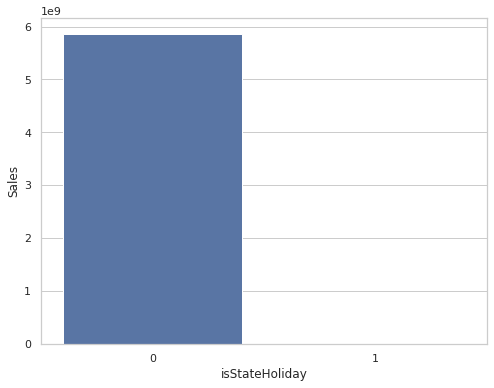

In [ ]:
sns.set_theme(style="whitegrid")
rossmann_plot_df = rossmann_df.groupby('isStateHoliday').agg({'Sales': 'sum'}).reset_index()
ax = sns.barplot(x=rossmann_plot_df.isStateHoliday, y=rossmann_plot_df.Sales)

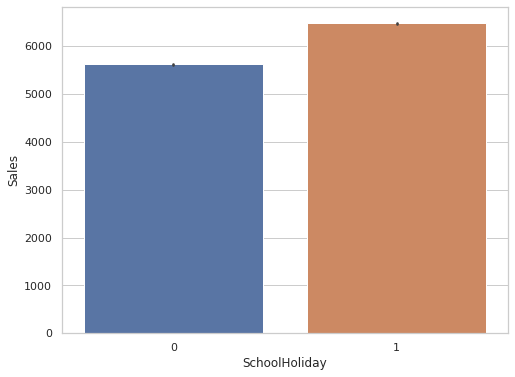

In [ ]:
ax = sns.barplot(x="SchoolHoliday", y="Sales", data=rossmann_df)

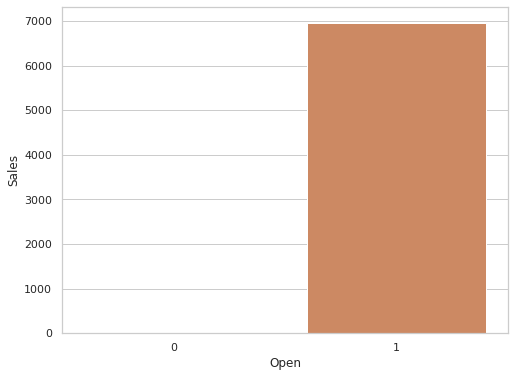

In [ ]:
ax = sns.barplot(x="Open", y="Sales", data=rossmann_df)

In [ ]:
ax = sns.barplot(x=rossmann_df.Promo, y=np.sum(rossmann_df.Sales))

AttributeError: ignored

In [ ]:
rossmann_df[rossmann_df['SchoolHoliday'] == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
12,13,5,2015-07-31,8821,568,1,1,0,0
19,20,5,2015-07-31,9593,974,1,1,0,0
21,22,5,2015-07-31,6566,633,1,1,0,0
31,32,5,2015-07-31,6395,635,1,1,0,0
35,36,5,2015-07-31,12422,1251,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1014946,1082,4,2013-01-03,7303,1185,1,0,0,0
1014954,1090,4,2013-01-03,4607,689,1,0,0,0
1014957,1093,4,2013-01-03,8371,882,1,0,0,0
1014962,1098,4,2013-01-03,4591,675,1,0,0,0


In [ ]:
rossmann_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
rossmann_df['StateHoliday_modified'] = rossmann_df['StateHoliday'].apply(lambda x: str(x))
rossmann_df['StateHoliday_modified'] = rossmann_df['StateHoliday_modified'].apply(lambda x: x.strip())
rossmann_df['StateHoliday_modified'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday_modified, dtype: int64

In [ ]:
rossmann_df[rossmann_df['Open']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_modified
291,292,5,2015-07-31,0,0,0,1,0,1,0
875,876,5,2015-07-31,0,0,0,1,0,1,0
1406,292,4,2015-07-30,0,0,0,1,0,1,0
1990,876,4,2015-07-30,0,0,0,1,0,1,0
2521,292,3,2015-07-29,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a
1017205,1112,2,2013-01-01,0,0,0,0,a,1,a
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a


In [ ]:
rossmann_df.shape

(1017209, 9)

In [ ]:
rossmann_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
pd.concat([store_df.head(),store_df.tail()])

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
